In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [22]:
#定义常量
rnn_unit=10       #hidden layer units
input_size=10
output_size=1
lr=0.0006         #学习率
#——————————————————导入数据——————————————————————
f=open('/Users/chocolatekuma/Desktop/600519.csv') 
df=pd.read_csv(f)     #读入股票数据
df=df.iloc[1:,:]
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['date'],inplace = True)
df['last close'] = df['last close'].astype('float')
df['% change'] = df['% change'].astype('float')
df['money'] = df['money'].astype('float')
data=df.iloc[:,1:].values  #取第3-10列
data.shape

(4028, 11)

In [23]:
#获取训练集
def get_train_data(batch_size=60,time_step=20,train_begin=0,train_end=3200):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #标准化
    train_x,train_y=[],[]   #训练集 
    for i in range(len(normalized_train_data)-time_step):
       if i % batch_size==0:
           batch_index.append(i)
       x=normalized_train_data[i:i+time_step,:10]
       y=normalized_train_data[i:i+time_step,10,np.newaxis]
       train_x.append(x.tolist())
       train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

In [24]:
#获取测试集
def get_test_data(time_step=20,test_begin=3200):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  #标准化
    size=(len(normalized_test_data)+time_step-1)//time_step  #有size个sample 
    test_x,test_y=[],[]  
    for i in range(size-1):
       x=normalized_test_data[i*time_step:(i+1)*time_step,:10]
       y=normalized_test_data[i*time_step:(i+1)*time_step,10]
       test_x.append(x.tolist())
       test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:10]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,10]).tolist())
    return mean,std,test_x,test_y

In [25]:
#——————————————————定义神经网络变量——————————————————
#输入层、输出层权重、偏置

weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }

In [26]:
#——————————————————定义神经网络变量——————————————————
def lstm(X):     
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']  
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    with tf.variable_scope('lstm') as scope:
        cell=tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32,scope = 'lstm')  
    #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [27]:
#——————————————————训练模型——————————————————


def train_lstm(batch_size=80,time_step=15,train_begin=0,train_end=3200):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    pred,_=lstm(X)
    
    mean,std,test_x,test_y=get_test_data(time_step)
    
    #损失函数
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    #saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
    #module_file = tf.train.latest_checkpoint()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #saver.restore(sess, module_file)
        #重复训练10000次
        for i in range(1001):
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
            
            if i % 200==0:
                print(i,loss_)
             #   print("保存模型：",saver.save(sess,'stock2.model',global_step=i))
        test_predict=[]
        for step in range(len(test_x)-1):
          prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
          predict=prob.reshape((-1))
          test_predict.extend(predict)
        test_y=np.array(test_y)*std[10]+mean[10]
        test_predict=np.array(test_predict)*std[10]+mean[10]
        print(test_predict)
        acc=1- np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  #偏差
        print("accuracy: ", acc)
        #以折线图表示结果
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b')
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.show()


0 0.985758
200 0.00459549
400 0.00263112
600 0.00194125
800 0.00175261
1000 0.00169924
[ 193.55160522  202.38752747  198.50308228  204.14389038  203.98921204
  204.184021    204.54769897  208.71635437  207.31526184  199.03288269
  204.17892456  199.03262329  203.2180481   196.91616821  208.09388733
  197.67941284  194.40075684  195.24804688  197.7565918   202.89749146
  204.14888     188.41929626  210.04138184  187.24227905  196.76005554
  200.23658752  212.54321289  215.8163147   205.83308411  214.045578
  244.50582886  236.85011292  245.03010559  233.86088562  246.64430237
  230.24665833  262.52603149  254.94735718  263.0847168   236.14736938
  246.36334229  242.30450439  260.09179688  259.69610596  264.88183594
  258.46844482  267.15997314  253.49763489  258.11087036  258.05700684
  255.61148071  269.74603271  272.46887207  293.25369263  285.88671875
  282.66726685  264.98846436  264.2644043   267.44622803  265.39605713
  272.94998169  243.04103088  242.45396423  248.49636841  248.5

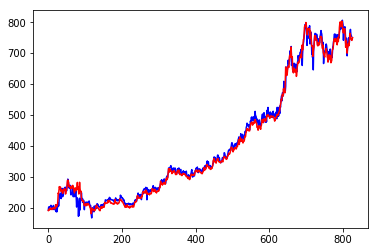

In [28]:
train_lstm()

In [ ]:
def predict():
    